R² Score: 0.359
RMSE: 667.908


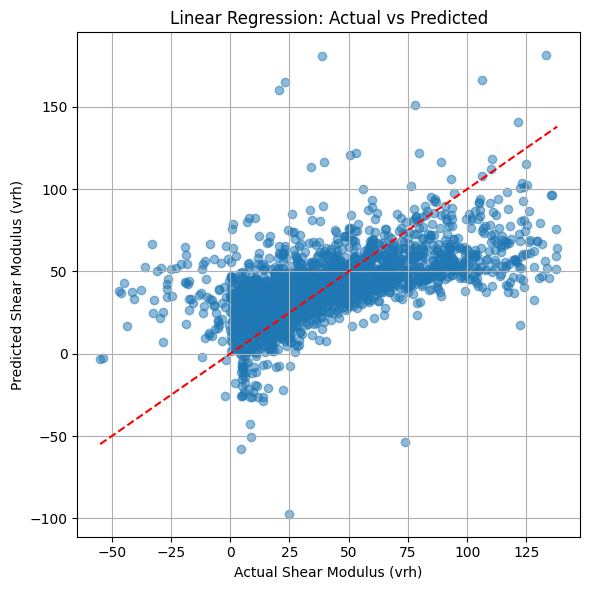

In [ ]:
import pandas as pd
import re
from collections import defaultdict
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("/content/elastic_properties_dataset.csv")

# Extract 'vrh' value from shear_modulus field
import ast
def extract_vrh(modulus_entry):
    try:
        parsed = ast.literal_eval(modulus_entry)
        return parsed.get("vrh", None)
    except:
        return None

df["shear_vrh"] = df["shear_modulus"].apply(extract_vrh)
df = df.dropna(subset=["shear_vrh", "formula"])

# Remove outliers using IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[column] >= Q1 - 1.5 * IQR) & (df[column] <= Q3 + 1.5 * IQR)]

df = remove_outliers_iqr(df, "shear_vrh")

# Parse chemical formula to get element counts
element_pattern = re.compile("([A-Z][a-z]*)([0-9\.]*)")

def parse_formula(formula):
    elements = defaultdict(float)
    for (el, count) in element_pattern.findall(formula):
        elements[el] += float(count) if count else 1.0
    return dict(elements)

element_df = df["formula"].apply(parse_formula)
X = pd.json_normalize(element_df).fillna(0)
y = df["shear_vrh"]

# Split into train (60%), val (20%), test (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Train Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and evaluate on test set
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)

print(f"R² Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")

# Plot actual vs predicted
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Shear Modulus (vrh)")
plt.ylabel("Predicted Shear Modulus (vrh)")
plt.title("Linear Regression: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()


Random Forest R² Score: 0.393
Random Forest RMSE: 632.251


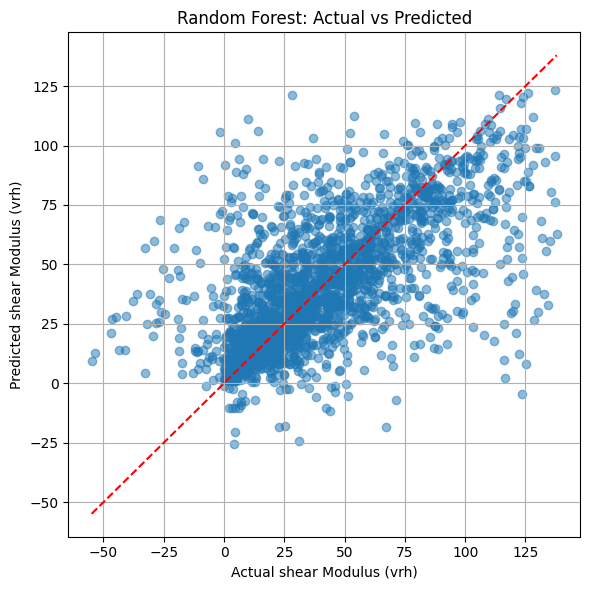

In [ ]:
import pandas as pd
import re
from collections import defaultdict
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import ast

# Load the dataset
df = pd.read_csv("/content/elastic_properties_dataset.csv")

# Extract 'vrh' value from shear_modulus field
def extract_vrh(modulus_entry):
    try:
        parsed = ast.literal_eval(modulus_entry)
        return parsed.get("vrh", None)
    except:
        return None

df["shear_vrh"] = df["shear_modulus"].apply(extract_vrh)
df = df.dropna(subset=["shear_vrh", "formula"])

# Remove outliers using IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[column] >= Q1 - 1.5 * IQR) & (df[column] <= Q3 + 1.5 * IQR)]

df = remove_outliers_iqr(df, "shear_vrh")

# Parse chemical formula to element count features
element_pattern = re.compile("([A-Z][a-z]*)([0-9\.]*)")
def parse_formula(formula):
    elements = defaultdict(float)
    for (el, count) in element_pattern.findall(formula):
        elements[el] += float(count) if count else 1.0
    return dict(elements)

element_df = df["formula"].apply(parse_formula)
X = pd.json_normalize(element_df).fillna(0)
y = df["shear_vrh"]

# Split the dataset: 60% train, 20% validation, 20% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Train the Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate on test set
y_pred = rf.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)

print(f"Random Forest R² Score: {r2:.3f}")
print(f"Random Forest RMSE: {rmse:.3f}")

# Plot actual vs predicted
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual shear Modulus (vrh)")
plt.ylabel("Predicted shear Modulus (vrh)")
plt.title("Random Forest: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()


SVR R² Score: 0.500
SVR RMSE: 520.94


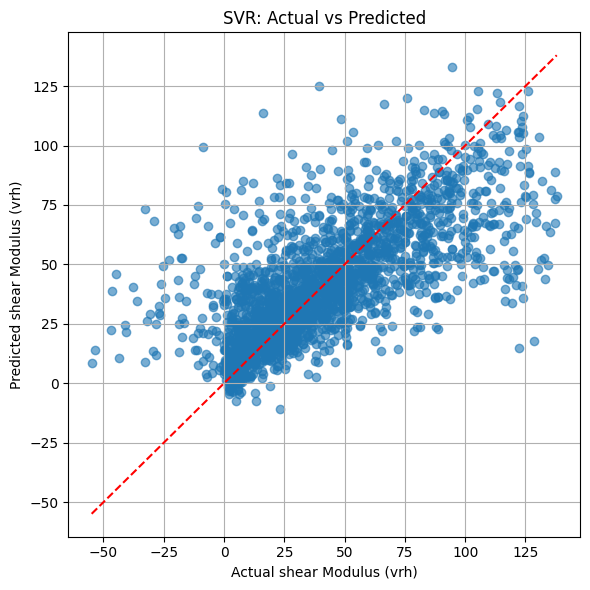

In [ ]:
import pandas as pd
import re
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import ast

# --- Step 1: Load dataset and extract bulk modulus 'vrh' values ---
df = pd.read_csv("/content/elastic_properties_dataset.csv")

def extract_vrh(modulus_entry):
    try:
        parsed = ast.literal_eval(modulus_entry)
        return parsed.get("vrh", None)
    except:
        return None

df["shear_vrh"] = df["shear_modulus"].apply(extract_vrh)
df = df.dropna(subset=["shear_vrh", "formula"])

# --- Step 2: Remove outliers ---
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[column] >= Q1 - 1.5 * IQR) & (df[column] <= Q3 + 1.5 * IQR)]

df = remove_outliers_iqr(df, "shear_vrh")

# --- Step 3: Convert chemical formula into element count features ---
element_pattern = re.compile("([A-Z][a-z]*)([0-9\.]*)")

def parse_formula(formula):
    elements = defaultdict(float)
    for (el, count) in element_pattern.findall(formula):
        elements[el] += float(count) if count else 1.0
    return dict(elements)

element_df = df["formula"].apply(parse_formula)
X = pd.json_normalize(element_df).fillna(0)
y = df["shear_vrh"]

# --- Step 4: Split and scale data ---
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Scale features (SVR is sensitive to feature scales)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Step 5: Train SVR model ---
svr = SVR(kernel='rbf', C=100, epsilon=0.1)
svr.fit(X_train_scaled, y_train)

# --- Step 6: Evaluate model ---
y_pred = svr.predict(X_test_scaled)
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)

print(f"SVR R² Score: {r2:.3f}")
print(f"SVR RMSE: {rmse:.2f}")

# --- Step 7: Plot Actual vs Predicted ---
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual shear Modulus (vrh)")
plt.ylabel("Predicted shear Modulus (vrh)")
plt.title("SVR: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()
